<a href="https://colab.research.google.com/github/sadnyd/Employee-Attrition/blob/main/llmextract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import google.generativeai as genai
import pandas as pd
import os

# Manually set the API key here
api_key = ''  # Replace this with your actual GEMINI API key
genai.configure(api_key=api_key)

# Function to generate entities from the prompt
def generate_entities(prompt):
    model = genai.GenerativeModel(model_name='gemini-pro')
    response = model.generate_content(prompt)
    return response.text

# Function to generate a prompt based on the content type (CV or JD)
def generate_prompt(text, info):
    if info == "CV":
        prompt = '''
        You are an entity extraction expert, you can identify and extract different types of entities from a text. Here is some information from a CV. Your task is to find and enlist all the information entities like education (degree, grade, school name), skills (which skills they have), qualifications (skills), experience (action verb and nouns) and any other helpful token that is important for a job, and share them in a list where entities are separated by commas. Do not write anything else. Just the small entities separated by commas in a dictionary (json). Each entity can have only 1-2 words.
        '''
        prompt = prompt + "```" + text + "```"
    else:
        prompt = '''
        You are an entity extraction expert, you can identify and extract different types of entities from a text. Here is some information from a job description. Your task is to find and enlist all the information entities like education (degree requirement), skills (which skills the job needs), qualifications (skills), experience (action verb and nouns), and any other helpful token that is important for a job, and share them in a list where entities are separated by commas. Do not write anything else. Just the small entities separated by commas in a dictionary (json). Each entity can have only 1-2 words. Do not share details.
        '''
        prompt = prompt + "```" + text + "```"

    prompt = prompt + '''
    =================
    Example:
    {
        'Education': ['ABC University', 'CGPA 3.00', 'Computer Science and Engineering', 'BSc'],
        'Skills': ['C', 'Python', 'R', 'Machine Learning', 'Communication', 'Team Work'],
        'Experience': {'ABX InfoTech': ['Team Management', 'Assistant Manager'], 'STech': ['Manager', 'Senior Engineer', 'AWS']},
    }
    '''
    return prompt

# Reading job descriptions and CVs
for dirname, _, filenames in os.walk('/content/drive/MyDrive/knowledgeGraph'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load CSV files containing job descriptions (JD) and CVs
JD = pd.read_csv("/content/drive/MyDrive/knowledgeGraph/Selected JDs.csv")
CV = pd.read_csv("/content/drive/MyDrive/knowledgeGraph/Selected CVs.csv")

# Initialize the output lists
outputs_JD = []
outputs_CV = []

# Check if the output CSV file exists, create if not
output_csv = "/content/drive/MyDrive/knowledgeGraph/outputs.csv"
file_exists = os.path.exists(output_csv)

# Process the job descriptions and CVs
for i in range(200):
    JD_i = JD['jobpost'][i]
    CV_i = CV['Resume_str'][i]

    print("Processing:", i + 1)

    JD_t = ''
    CV_t = ''

    try:
        JD_t = generate_entities(generate_prompt(JD_i, "JD"))
        print("JD:", JD_t)
    except Exception as e:
        print("JD Failed:", e)

    try:
        CV_t = generate_entities(generate_prompt(CV_i, "CV"))
        print("CV:", CV_t)
    except Exception as e:
        print("CV Failed:", e)

    # Append the outputs to the lists
    outputs_JD.append(JD_t)
    outputs_CV.append(CV_t)

    # Save to CSV immediately after processing each pair
    dfx = pd.DataFrame({
        'Outputs_JD': [JD_t],
        'Outputs_CV': [CV_t]
    })

    if file_exists:
        # If the file exists, append data
        dfx.to_csv(output_csv, mode='a', header=False, index=False)
    else:
        # If the file doesn't exist, write the header
        dfx.to_csv(output_csv, mode='w', header=True, index=False)

    # Sleep to avoid hitting rate limits
    time.sleep(0.5)

# Once all the outputs are processed, save them to the final CSV
# (This step is redundant since the outputs are saved immediately after each iteration)
# dfx = pd.DataFrame({
#     'Outputs_JD': outputs_JD,
#     'Outputs_CV': outputs_CV
# })
# dfx.to_csv("outputs.csv", index=False)

Streaming output truncated to the last 5000 lines.
    "multi",
    "-faceted",
    "HR",
    "communication",
    "channels",
    "strategy",
    "including",
    "web",
    "-",
    "based",
    "solutions",
    "total",
    "rewards",
    "statements",
    "on",
    "-line",
    "enrollment",
    "Incorporated",
    "diversity",
    "focus",
    "benefits",
    "programs",
    "policies",
    "Created",
    "extensive",
    "health",
    "management",
    "programs",
    "increase",
    "engagement",
    "drive",
    "cost",
    "evolution",
    "toward",
    "outcome",
    "based",
    "programs",
    "Developed",
    "implemented",
    "overall",
    "benefits",
    "strategy",
    "adding",
    "several",
    "employee",
    "wellness",
    "activities",
    "events",
    "cost",
    "Consolidated",
    "several",
    "medical",
    "plans",
    "resulting",
    "improved",
    "benefit",
    "levels",
    "reporting",
    "satisfaction",
    "reduction",
    "annual",
    "expen

In [ ]:
import os
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
import pickle

LLM_OUTPUTS = "/content/drive/MyDrive/knowledgeGraph/outputs.csv"

ENTITY = pd.read_csv(LLM_OUTPUTS)

# Pre-Processing all at once
ENTITY["Outputs_JD"] = ENTITY["Outputs_JD"].apply(lambda x: re.sub(r"(\n|json|```|degree| in | of )", "", str(x)))
ENTITY["Outputs_CV"] = ENTITY["Outputs_CV"].apply(lambda x: re.sub(r"(\n|json|```|degree| in | of )", "", str(x)))

# Ensure the 'individuals' directory exists
if not os.path.exists('/content/drive/MyDrive/knowledgeGraph/individuals'):
    os.makedirs('/content/drive/MyDrive/knowledgeGraph/individuals')

# Function to visualize job descriptions and CVs
def visualize_job_description(text, G_id, max_node_length=4):
    text2 = text.lower()

    # text pre-processing
    text2 = re.sub(r"(\w+)'s", r"\1s", text2)
    text2 = text2.replace('null', 'None').replace('none', 'None')

    # Convert the text to a dictionary
    try:
        job_description = eval(text2)
    except Exception as e:
        print(f"Error parsing text to dictionary for {G_id}: {e}")
        return None

    # Create a directed graph
    G = nx.DiGraph()
    G.add_node(G_id, label=G_id)

   # Add nodes and edges to the graph
    for category, items in job_description.items():
        if not items or not isinstance(items, (list, dict)):  # Check if items is valid and iterable
            continue

        for item in items:
            if isinstance(item, dict):
                try:
                    cn = item.get('Company Name', "Company")
                    jt = item.get('Job Title', "Job Title not specified")
                    if (jt == "Job Title not specified") or (cn == "Job Title not specified"):
                        continue
                    G.add_edge(G_id, jt)
                    G.edges[G_id, jt]['label'] = category
                    if cn:
                        G.add_edge(G_id, cn)
                        G.edges[G_id, cn]['label'] = category
                        G.add_edge(jt, cn)
                        G.edges[jt, cn]['label'] = 'Job Skill'
                except Exception as e:
                    print(f"Error processing job description for {G_id}: {e}")
                    continue
            elif isinstance(item, list):
                continue
            elif len(item.split()) <= max_node_length:
                G.add_node(item, label=item)
                G.add_edge(G_id, item)
                G.edges[G_id, item]['label'] = category


    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Visualize the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'label')
    node_labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, font_size=8, node_size=700, node_color='skyblue', font_color='black', font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black', font_weight='bold')

    # Save the figure locally
    plt.savefig(f"/content/drive/MyDrive/knowledgeGraph/individuals/{G_id}.png")
    plt.close()

    return G

# Loop through the data
JD_Graphs, CV_Graphs = {}, {}

for i in range(0, 200):
    # Process JD
    jd_text = ENTITY["Outputs_JD"][i]
    JD_i = visualize_job_description(jd_text, f"JD_{i}")
    if JD_i:
        JD_Graphs[i] = JD_i
    print(f"{i} JD: Done")

    # Process CV
    cv_text = ENTITY["Outputs_CV"][i]
    CV_i = visualize_job_description(cv_text, f"CV_{i}")
    if CV_i:
        CV_Graphs[i] = CV_i
    print(f"{i} CV: Done")

# Save the list to a file in one go
with open('JD_Graphs.pkl', 'wb') as file:
    pickle.dump(JD_Graphs, file)
with open('CV_Graphs.pkl', 'wb') as file:
    pickle.dump(CV_Graphs, file)


0 JD: Done
0 CV: Done
1 JD: Done
1 CV: Done
2 JD: Done
2 CV: Done
3 JD: Done
3 CV: Done
4 JD: Done
4 CV: Done
5 JD: Done
5 CV: Done
6 JD: Done
6 CV: Done
7 JD: Done
Error parsing text to dictionary for CV_7: invalid syntax (<string>, line 1)
7 CV: Done
8 JD: Done
8 CV: Done
9 JD: Done
Error parsing text to dictionary for CV_9: closing parenthesis '}' does not match opening parenthesis '[' (<string>, line 1)
9 CV: Done
10 JD: Done
Error parsing text to dictionary for CV_10: invalid syntax (<string>, line 1)
10 CV: Done
11 JD: Done
11 CV: Done
12 JD: Done
12 CV: Done
13 JD: Done
13 CV: Done
14 JD: Done
Error parsing text to dictionary for CV_14: closing parenthesis ']' does not match opening parenthesis '{' (<string>, line 1)
14 CV: Done
15 JD: Done
Error parsing text to dictionary for CV_15: invalid decimal literal (<string>, line 1)
15 CV: Done
16 JD: Done
16 CV: Done
17 JD: Done
Error parsing text to dictionary for CV_17: unterminated string literal (detected at line 1) (<string>, lin

In [ ]:
ENTITY.head()

,Outputs_JD,Outputs_CV
0,"{ 'Education': ['Computer Sciences', 'Bachelo...","{ ""Education"": [ ""AssociateScience"", ""N..."


In [ ]:
ENTITY.columns


Index(['Outputs_JD', 'Outputs_CV'], dtype='object')

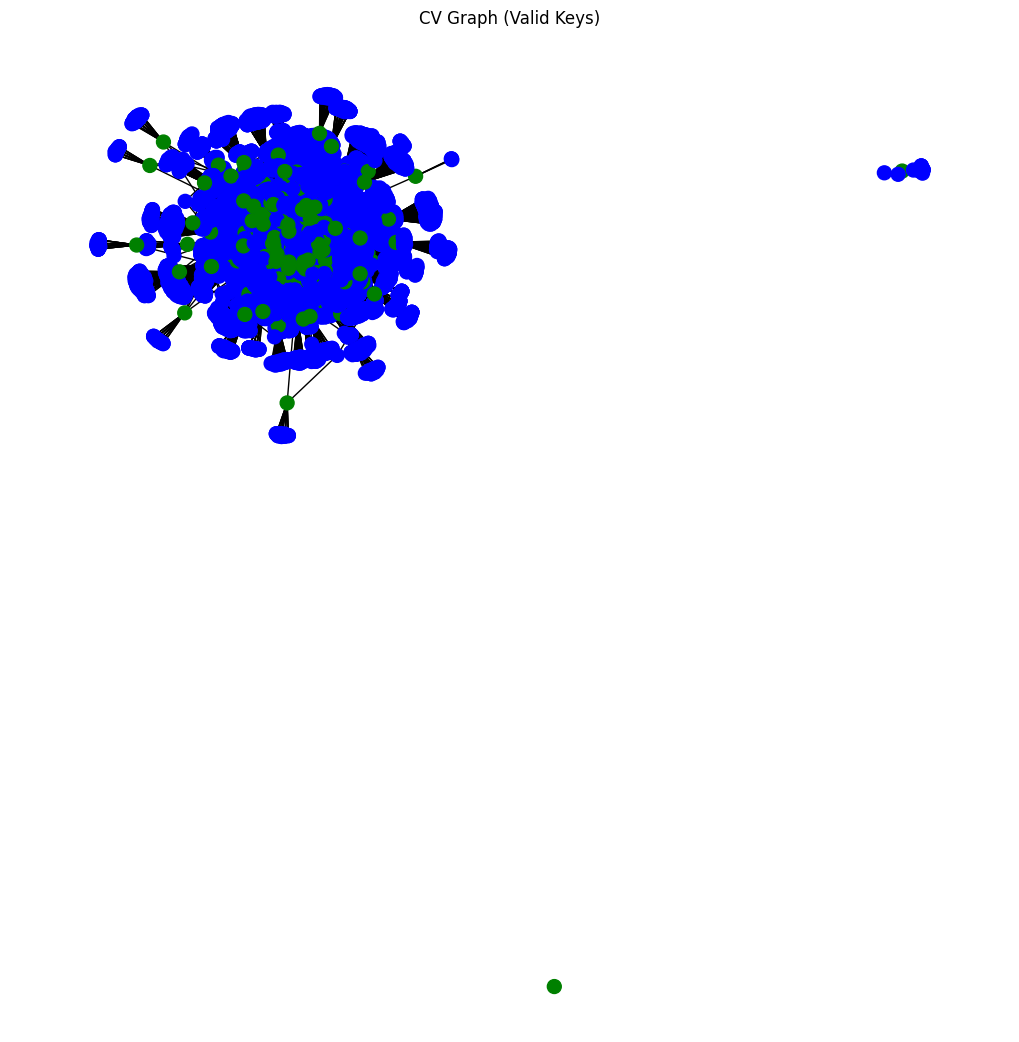

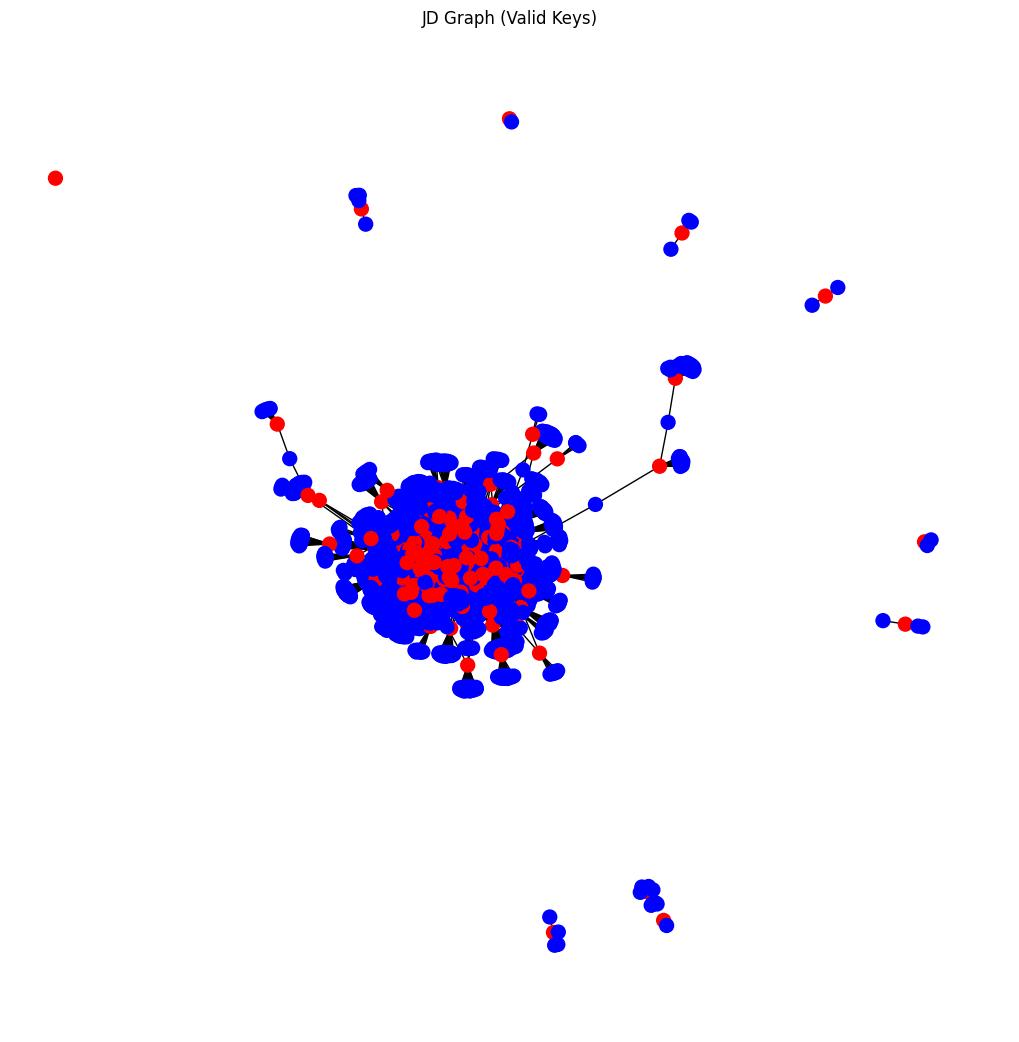

In [12]:
# Function to combine graphs into a mega graph
def combine_graphs(graphs):
    mega_graph = nx.Graph()
    for graph in graphs:
        mega_graph.add_nodes_from(graph.nodes(data=True))
        mega_graph.add_edges_from(graph.edges(data=True))
    return mega_graph

# Get valid keys and combine graphs
valid_CV_keys = CV_Graphs.keys()
valid_JD_keys = JD_Graphs.keys()

G_CV = combine_graphs([CV_Graphs[i] for i in valid_CV_keys])
G_JD = combine_graphs([JD_Graphs[i] for i in valid_JD_keys])

# Function to plot a graph with colors
def plot_graph(G, node_colors, title="Graph"):
    pos = nx.spring_layout(G, seed=42)  # Ensure consistent layout
    plt.figure(figsize=(10, 10))

    # Draw the graph with specified node colors
    nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, font_size=8)
    plt.title(title)
    plt.show()

# Node color assignment for CV and JD
def assign_node_colors(G, prefix="CV"):
    node_colors = []
    for node in G.nodes():
        if node.startswith(prefix):
            node_colors.append('green' if prefix == "CV" else 'red')
        else:
            node_colors.append('blue')
    return node_colors

# Plot the CV and JD graphs
node_colors_CV = assign_node_colors(G_CV, prefix="CV")
plot_graph(G_CV, node_colors_CV, title="CV Graph (Valid Keys)")

node_colors_JD = assign_node_colors(G_JD, prefix="JD")
plot_graph(G_JD, node_colors_JD, title="JD Graph (Valid Keys)")

# Save the combined graphs as pickle files
with open('CV_FKG.pkl', 'wb') as file:
    pickle.dump(G_CV, file)

with open('JD_FKG.pkl', 'wb') as file:
    pickle.dump(G_JD, file)


Available pinned nodes: ['bachelors', 'analytical skills', 'communication', 'problem solving', 'english', 'communicate', 'read', 'computer literacy', 'electronics', 'negotiate contracts', 'risk assessment', 'hardware troubleshooting', 'testing', 'computer science', 'adobe flash', 'sql', 'css', 'xml', 'linux', 'interpersonal', 'developing', 'maintaining', 'finance', 'economics', 'accounting', 'ms excel', 'data analysis', 'interpersonal skills', 'computer skills', 'management', 'engineering', 'managing', 'installing', 'reporting', 'training', 'coordinating', 'hvac', 'technology', 'repair', 'maintenance', 'excel', 'accurate', 'detail oriented', 'operations', 'assist', 'prepare', 'support', 'programming', 'supervision', 'modification', 'ms office', 'communication skills', 'establishing', 'providing', 'bs', 'c#', 'asp.net', 'http', 'requirements', 'design', 'java', 'html', 'javascript', 'mvc', 'oracle', 'visio', 'unix', 'solaris', 'windows', 'team player', 'strong interpersonal skills', 'se

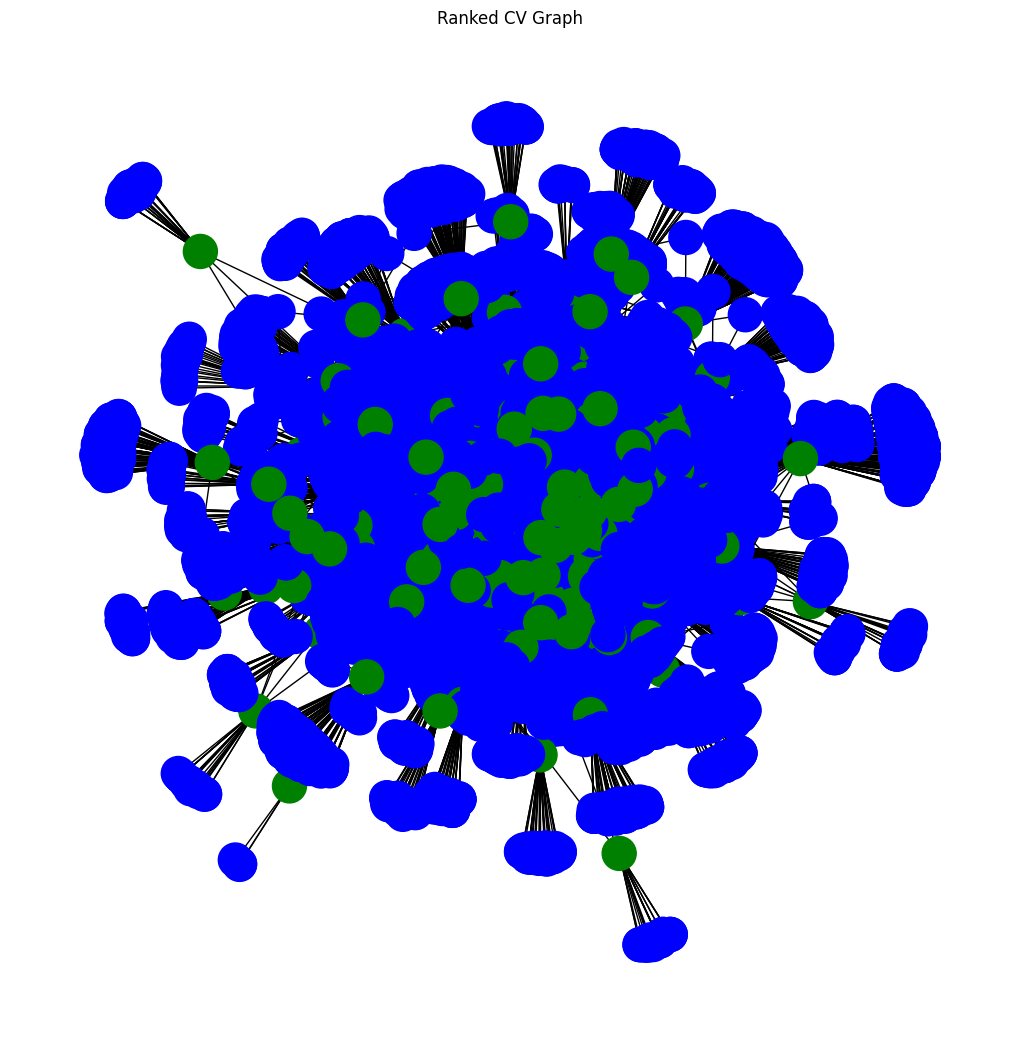

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
import matplotlib

# Load graphs
ALL_CV_FULL_KG = "CV_FKG.pkl"  # path to your CV graphs as pkl
ALL_JD_FULL_KG = "JD_FKG.pkl"  # path to your JD graphs as pkl
with open(ALL_CV_FULL_KG, 'rb') as file:
    G_CV = pickle.load(file)
with open(ALL_JD_FULL_KG, 'rb') as file:
    G_JD = pickle.load(file)

# Remove missing nodes from a list
def remove_missing_nodes(graph, nodes):
    return [node for node in nodes if graph.has_node(node)]

# Rank unpinned nodes by degree centrality and filter by a prefix
def rank_unpinned_nodes(graph, pinned_nodes, prefix_filter=None):
    # Clean up pinned nodes by removing missing ones
    pinned_nodes = remove_missing_nodes(graph, pinned_nodes)
    print('Available pinned nodes:', pinned_nodes)

    # Collect neighbors of pinned nodes (including 2-hop neighbors)
    neighbors_of_pinned_nodes = set()
    for node in pinned_nodes:
        neighbors_of_pinned_nodes.update(graph.neighbors(node))
        # Add 2-hop neighbors
        for neighbor in graph.neighbors(node):
            neighbors_of_pinned_nodes.update(graph.neighbors(neighbor))

    # Create a subgraph from pinned nodes and their 2-hop neighbors
    subgraph = graph.subgraph(pinned_nodes + list(neighbors_of_pinned_nodes))

    # Compute degree centrality for the nodes in the subgraph
    node_ranks = nx.degree_centrality(subgraph)

    # Sort unpinned nodes by their rank in descending order
    unpinned_nodes = [node for node in graph.nodes() if node not in pinned_nodes and node_ranks.get(node) is not None]
    sorted_unpinned_nodes = sorted(unpinned_nodes, key=node_ranks.get, reverse=True)

    # Filter nodes based on prefix (e.g., "CV_" or "JD_")
    if prefix_filter:
        sorted_unpinned_nodes = [node for node in sorted_unpinned_nodes if str(node).startswith(prefix_filter)]
        serial = [int(node.split("_")[1]) for node in sorted_unpinned_nodes]
    else:
        serial = []

    return sorted_unpinned_nodes, serial, subgraph

# Define pinned nodes (using JD Graph 3)
pinned_nodes = list(G_JD.nodes())

# Rank unpinned nodes for CV graphs, filtering by "CV_"
ranked_unpinned_nodes, job_no, subgraph = rank_unpinned_nodes(G_CV, pinned_nodes, prefix_filter="CV_")

# Print recommended JD numbers
print("Recommended JD Nos:", job_no)

# Assign colors to nodes based on prefix
def assign_node_colors(subgraph, prefix_filter="CV"):
    node_colors = []
    for node in subgraph.nodes():
        if node.startswith(prefix_filter):
            node_colors.append('green' if prefix_filter == "CV" else 'red')
        else:
            node_colors.append('blue')
    return node_colors

# Assign node colors for the subgraph
node_colors = assign_node_colors(subgraph, prefix_filter="CV")

# Plot the graph using NetworkX
def plot_subgraph(subgraph, node_colors):
    pos = nx.spring_layout(subgraph, seed=42)  # Ensure consistent layout
    plt.figure(figsize=(10, 10))
    nx.draw(subgraph, pos, with_labels=False, node_size=600, node_color=node_colors)
    plt.title("Ranked CV Graph")
    plt.show()

# Plot the subgraph
plot_subgraph(subgraph, node_colors)

# Save the combined subgraph to a pickle file
with open('CV_FKG_ranked.pkl', 'wb') as file:
    pickle.dump(subgraph, file)
